# Exploratory Data Analysis and Visualization

# Introduction

Have you ever wondered how does an e-commerce websites display options such as "Frequently Bought Together"?
Such systems are called Recommender Systems, Recommendation Systems, or Recommendation Engines. It is one of 
the most famous applications of data science and machine learning.
More and more consumers seek product information from other consumers apart from the information provided by the seller. Reviews and ratings submitted by consumers are examples of such of type of information and they have already become an integral part of customer’s buying-decision process. The review and ratings platform provided by eCommerce players creates transparent system for consumers to take informed decision and feel confident about it.

## Dataset

- The Amazon Dataset (Apps for Androids) is used for analysis and can be found here: .
- It contains over 750,000 reviews of Amazon Apps for Androids applied to 13,200 products by 87,000 users.
- It consists of the following information:
    - UserID
    - ProductID
    - UserName
    - UserNickname
    - Number of people who have voted if this review is helpful or not
    - Number of people who have voted that the review is helpful
    - Rating (1 - 5 stars)
    - Review
    - A summary of the review
    - Timestamp of the review


In [1]:
from scipy import sparse
from scipy.sparse.linalg import svds

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.utils.data as data


# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Loading the Data

In [2]:
# Reading the data provided via http://jmcauley.ucsd.edu/data/amazon/
def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
# Read the json file
df_Apps = getDF("data/Apps_for_Android_5.json")

In [6]:
# Checking for missing values
df_Apps.info()
# Observe that there are some missing values in reviewerName column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752937 entries, 0 to 752936
Data columns (total 9 columns):
reviewerID        752937 non-null object
asin              752937 non-null object
reviewerName      694739 non-null object
helpful           752937 non-null object
reviewText        752937 non-null object
overall           752937 non-null float64
summary           752937 non-null object
unixReviewTime    752937 non-null int64
reviewTime        752937 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 57.4+ MB


In [7]:
# Observing the shape of our data frame
print('We have {0} features and {1} data points'.format(df_Apps.shape[1], df_Apps.shape[0]))

We have 9 features and 752937 data points


In [8]:
# Printing first 5 columns from our data frame
df_Apps.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]","Loves the song, so he really couldn't wait to ...",3.0,Really cute,1383350400,"11 2, 2013"
1,A2HQWU6HUKIEC7,B004A9SDD8,"Audiobook lover ""Kathy""","[0, 0]","Oh, how my little grandson loves this app. He'...",5.0,2-year-old loves it,1323043200,"12 5, 2011"
2,A1SXASF6GYG96I,B004A9SDD8,Barbara Gibbs,"[0, 0]",I found this at a perfect time since my daught...,5.0,Fun game,1337558400,"05 21, 2012"
3,A2B54P9ZDYH167,B004A9SDD8,"Brooke Greenstreet ""Babylove""","[3, 4]",My 1 year old goes back to this game over and ...,5.0,We love our Monkeys!,1354752000,"12 6, 2012"
4,AFOFZDTX5UC6D,B004A9SDD8,C. Galindo,"[1, 1]",There are three different versions of the song...,5.0,This is my granddaughters favorite app on my K...,1391212800,"02 1, 2014"


In [9]:
# Value count on "Overall"
df_Apps.overall.value_counts()

5.0    386637
4.0    158081
3.0     85121
1.0     78713
2.0     44385
Name: overall, dtype: int64

In [10]:
# Feature-Engineering
df_Apps['HelpfulnessNumerator'] = df_Apps.helpful.apply(lambda x: x[0])
df_Apps['HelpfulnessDenominator'] = df_Apps.helpful.apply(lambda x: x[1])
df_Apps.drop(['helpful'], axis = 1)

#copying the original dataframe to 'temp_df'.
temp_df = df_Apps[['reviewerID','HelpfulnessNumerator','HelpfulnessDenominator', 'summary', 'reviewText','overall']].copy()

#Adding new features to dataframe.
temp_df["Sentiment"] = temp_df["overall"].apply(lambda overall: "positive" if overall > 3 else \
                                              ("negative" if overall < 3 else "not defined"))
temp_df["Helpfulness"] = (temp_df["HelpfulnessNumerator"]/temp_df["HelpfulnessDenominator"]).apply\
(lambda n: ">75%" if n > 0.75 else ("<25%" if n < 0.25 else ("25-75%" if n >= 0.25 and\
                                                                        n <= 0.75 else "useless")))

temp_df.loc[temp_df.HelpfulnessDenominator == 0, 'Helpfulness'] = ["useless"]
# Removing all rows where 'Score' is equal to 3
#temp_df = temp_df[temp_df.Score != 3]
#Lets now observe the shape of our new dataframe.
temp_df.shape

(752937, 8)

In [11]:
temp_df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,overall
count,752937.000000,752937.000000,752937.000000
mean,3.435937,4.473125,3.968931
std,37.328951,43.688824,1.342484
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,5.000000
75%,1.000000,2.000000,5.000000
max,8116.000000,9258.000000,5.000000


In [12]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752937 entries, 0 to 752936
Data columns (total 8 columns):
reviewerID                752937 non-null object
HelpfulnessNumerator      752937 non-null int64
HelpfulnessDenominator    752937 non-null int64
summary                   752937 non-null object
reviewText                752937 non-null object
overall                   752937 non-null float64
Sentiment                 752937 non-null object
Helpfulness               752937 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 51.7+ MB


### Positive reviews are very common

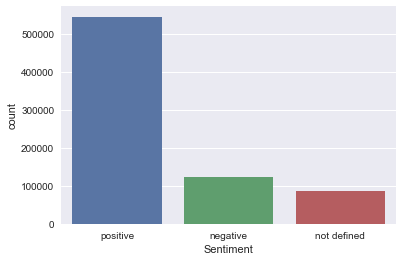

In [13]:
sns.countplot(x='Sentiment', order=["positive", "negative", "not defined"], data=temp_df)
plt.show()

In [14]:
temp_df.Sentiment.value_counts()

positive       544718
negative       123098
not defined     85121
Name: Sentiment, dtype: int64

We can conclude that the positive reviews are way more than the negative reviews.

## Helpfulness

### How many reviews are helpful?

In [15]:
# Checking the value count for "Usefulness"
temp_helpfulness_counts = temp_df.Helpfulness.value_counts()
temp_helpfulness_counts

useless    465672
>75%       146594
25-75%      87513
<25%        53158
Name: Helpfulness, dtype: int64

In [17]:
reviews_not_voted = temp_helpfulness_counts[0] / (temp_helpfulness_counts[1] + temp_helpfulness_counts[2] + temp_helpfulness_counts[3] + temp_helpfulness_counts[0]) * 100
print('Among all reviews, about {} % are not voted on at all'.format(reviews_not_voted))

Among all reviews, about 61.84740555982772 % are not voted on at all


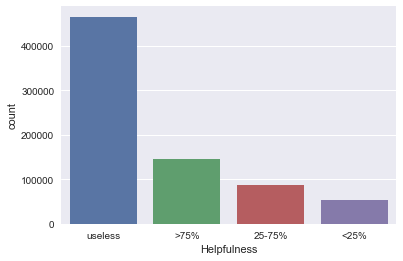

In [18]:
sns.countplot(x="Helpfulness", order=["useless", ">75%", "25-75%", "<25%"], data=temp_df)
plt.show()

### Positive reviews are more helpful for the users

### Ratings becomes more positive, the reviews become more helpful

In [19]:
temp_df[temp_df.overall==5].Helpfulness.value_counts()

useless    262867
>75%        75827
25-75%      29077
<25%        18866
Name: Helpfulness, dtype: int64

In [20]:
temp_df[temp_df.overall==1].Helpfulness.value_counts()

25-75%     24931
useless    23430
>75%       16434
<25%       13918
Name: Helpfulness, dtype: int64

## Word Count

In [21]:
temp_df["text_word_count"] = temp_df["reviewText"].apply(lambda text: len(text.split()))

In [22]:
temp_df.head()

,reviewerID,HelpfulnessNumerator,HelpfulnessDenominator,summary,reviewText,overall,Sentiment,Helpfulness,text_word_count
0,A1N4O8VOJZTDVB,1,1,Really cute,"Loves the song, so he really couldn't wait to ...",3.0,not defined,>75%,41
1,A2HQWU6HUKIEC7,0,0,2-year-old loves it,"Oh, how my little grandson loves this app. He'...",5.0,positive,useless,47
2,A1SXASF6GYG96I,0,0,Fun game,I found this at a perfect time since my daught...,5.0,positive,useless,52
3,A2B54P9ZDYH167,3,4,We love our Monkeys!,My 1 year old goes back to this game over and ...,5.0,positive,25-75%,40
4,AFOFZDTX5UC6D,1,1,This is my granddaughters favorite app on my K...,There are three different versions of the song...,5.0,positive,>75%,134


In [23]:
count_list = []
for i in range(1,6):
    count = temp_df[temp_df["overall"] == i].text_word_count.median()
    count_list.append(count)
print(count_list)

[31.0, 33.0, 31.0, 30.0, 29.0]


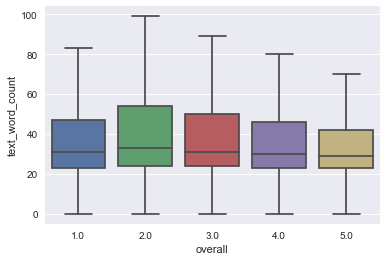

In [24]:
sns.boxplot(x="overall", y ="text_word_count", data=temp_df, showfliers=False)
plt.show()

5-star reviews had the lowest word count (29 words), while 2-star reviews had the largest word count (33 words).

How does word count relate to helpfulness?

/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


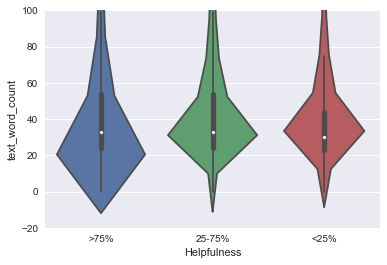

In [25]:
sns.violinplot(x="Helpfulness", y="text_word_count", order=[">75%", "25-75%", "<25%"], data=temp_df)
plt.ylim(-20, 100)
plt.show()

The reviews have a similar distribution with the greatest concentration of reviews of approximately 25-30 words. More helpful reviews have a larger concentraion of reviews with more words than less helpful reviews.

## Frequency of reviewers

Using User IDs, one can recognize repeat reviewers. Reviewers that have reviewed over 50 products account for over 5% of all reviews in the database. We will call such reviewers frequent reviewers. (The cutoff choice of 50, as opposed to another choice, seemed to not have a larger impact on the results.) I asked: Does the behavior of frequent reviewers differ from that of infrequent reviewers?

In [26]:
user_count = temp_df.reviewerID.value_counts()
#user_count.to_dict()

In [27]:
temp_df["reviewer_freq"] = temp_df.reviewerID.apply(lambda counts: "Frequent (>50 reviews)" if user_count[counts] > 50 else "Not Frequent (1-50)")

In [28]:
temp_df.head()

,reviewerID,HelpfulnessNumerator,HelpfulnessDenominator,summary,reviewText,overall,Sentiment,Helpfulness,text_word_count,reviewer_freq
0,A1N4O8VOJZTDVB,1,1,Really cute,"Loves the song, so he really couldn't wait to ...",3.0,not defined,>75%,41,Not Frequent (1-50)
1,A2HQWU6HUKIEC7,0,0,2-year-old loves it,"Oh, how my little grandson loves this app. He'...",5.0,positive,useless,47,Not Frequent (1-50)
2,A1SXASF6GYG96I,0,0,Fun game,I found this at a perfect time since my daught...,5.0,positive,useless,52,Not Frequent (1-50)
3,A2B54P9ZDYH167,3,4,We love our Monkeys!,My 1 year old goes back to this game over and ...,5.0,positive,25-75%,40,Not Frequent (1-50)
4,AFOFZDTX5UC6D,1,1,This is my granddaughters favorite app on my K...,There are three different versions of the song...,5.0,positive,>75%,134,Not Frequent (1-50)


## Are frequent reviews more discerning?

The distribution of ratings among frequent reviewers is similar to that of all reviews. However, we can see that frequent reviewers give less 5-star reviews and less 1-star review. Frequent users appear to be more discerning in the sense that they give less extreme reviews than infrequent reviews.

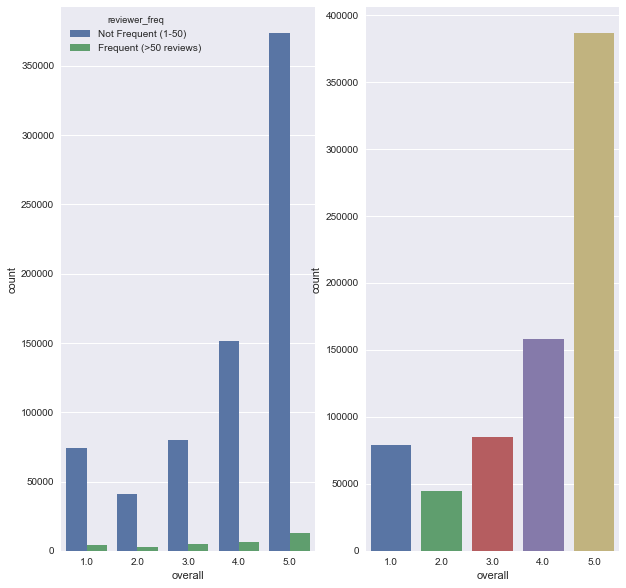

In [29]:
plt.figure(figsize=(10,10))
ax = plt.subplot(121)
sns.countplot(x="overall", hue="reviewer_freq", data=temp_df, ax=ax)

ax1 = plt.subplot(122)
sns.countplot(x="overall", data=temp_df, ax=ax1)
plt.show()

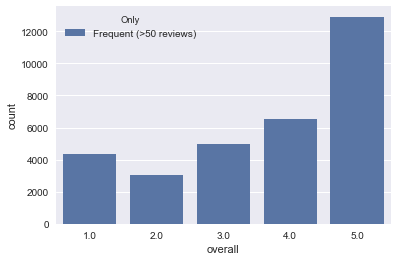

In [30]:
temp_df['Only'] = temp_df.reviewer_freq[temp_df.reviewer_freq == "Frequent (>50 reviews)"]
sns.countplot(x="overall", hue="Only", data=temp_df)
plt.show()

In [31]:
reviewer_freq_overall_count = temp_df[temp_df.reviewer_freq == "Frequent (>50 reviews)"].overall.value_counts()
total_reviewer_freq_overall_count = reviewer_freq_overall_count.sum()
reviewer_freq_overall_count = (reviewer_freq_overall_count / total_reviewer_freq_overall_count)*100

In [32]:
reviewer_Not_freq_overall_count = temp_df[temp_df.reviewer_freq == "Not Frequent (1-50)"].overall.value_counts()
total_reviewer_Not_freq_overall_count = reviewer_Not_freq_overall_count.sum()
reviewer_Not_freq_overall_count = (reviewer_Not_freq_overall_count / total_reviewer_Not_freq_overall_count)*100

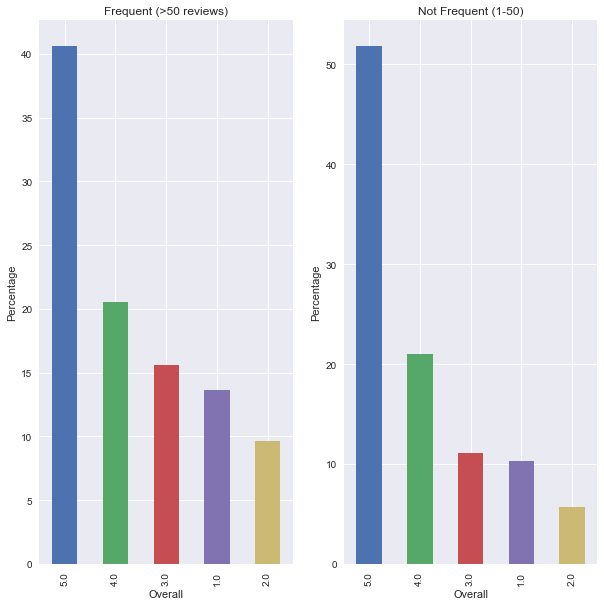

In [33]:
# Plotting
plt.figure(figsize=(10,10))
ax = plt.subplot(121)
reviewer_freq_overall_count.plot(kind="bar", ax=ax)
plt.xlabel("Overall")
plt.ylabel("Percentage")
plt.title("Frequent (>50 reviews)")

ax1 = plt.subplot(122)
reviewer_Not_freq_overall_count.plot(kind="bar", ax=ax1)
plt.xlabel("Overall")
plt.ylabel("Percentage")
plt.title("Not Frequent (1-50)")
plt.show()

### Are frequent reviewers more helpful?

The distribution of helpfulness for frequent reviewers is similar to that of all reviews. However, frequent reviewers are more likely to have their review voted on and when voted on, more likely to be voted helpful, and less likely to be unhelpful.

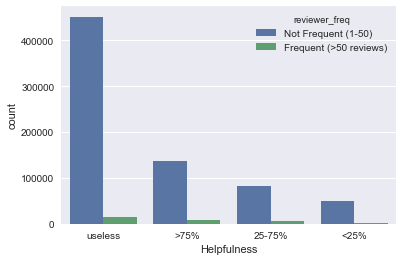

In [36]:
sns.countplot(x="Helpfulness", order=["useless", ">75%", "25-75%", "<25%"], hue="reviewer_freq", data=temp_df)
plt.show()

### Are frequent reviewers more verbose?

The distributions of word counts for frequent and infrequent reviews shows that infrequent reviewers have a large amount of reviews of low word count. Moreover, the median word count for frequent reviewers is higher than the median for infrequent reviewers.

/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


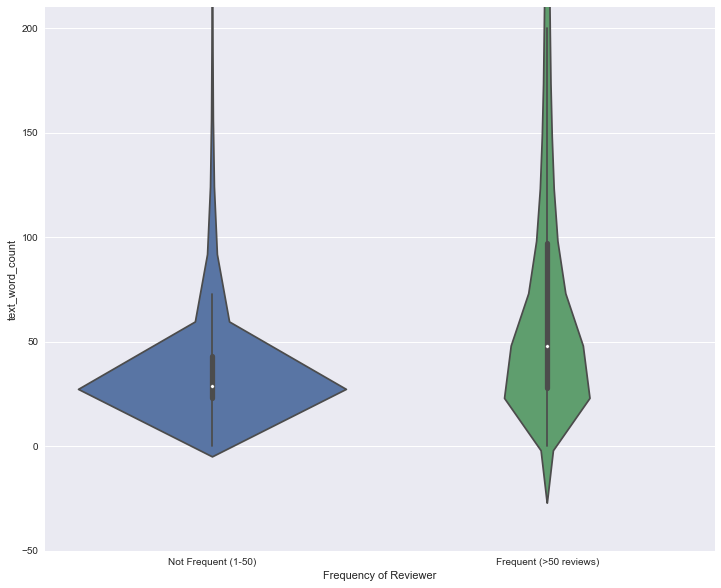

In [37]:
plt.figure(figsize=(12,10))
sns.violinplot(x="reviewer_freq", y="text_word_count", data=temp_df)
plt.ylim(-50,210)
plt.xlabel("Frequency of Reviewer")
plt.show()

#### Conclusion
- Positive reviews are very common
- Positive reviews are shorter
- Longer reviews are more helpful
- Despite being more common and shorter, positive reviews are found more helpful
- Frequent reviewers are more discerning in their ratings, write longer reviews, and write more helpful reviews

### Create a dataframe with users, items and ratings

In [38]:
df_Apps.reviewTime = pd.to_datetime(df_Apps.reviewTime)

In [39]:
df_user_item_rating = df_Apps[['reviewerID', 'asin', 'overall']]
df_user_item_rating.head()

,reviewerID,asin,overall
0,A1N4O8VOJZTDVB,B004A9SDD8,3.0
1,A2HQWU6HUKIEC7,B004A9SDD8,5.0
2,A1SXASF6GYG96I,B004A9SDD8,5.0
3,A2B54P9ZDYH167,B004A9SDD8,5.0
4,AFOFZDTX5UC6D,B004A9SDD8,5.0


In [40]:
# Save our cleaned data in csv
df_user_item_rating.to_csv('cleaned_user_item_rating.csv')

# Explorative Data Analysis (EDA)

In [41]:
# total number of ratings
total_num_ratings = len(df_user_item_rating.overall)
print('{} ratings'.format(total_num_ratings))

752937 ratings


In [42]:
# number of unique users
n_users = df_user_item_rating.reviewerID.unique().shape[0]
print('{} unique users'.format(n_users))

87271 unique users


In [43]:
# number of unique items
n_items = df_user_item_rating.asin.unique().shape[0]
print('{} unique items'.format(n_items))

13209 unique items


In [44]:
# sparsity of the user-item matrix
sparsity = float(total_num_ratings) / (n_users * n_items) * 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.07%


# Distribution of ratings

We first look at the distribution of ratings among all of the reviews.

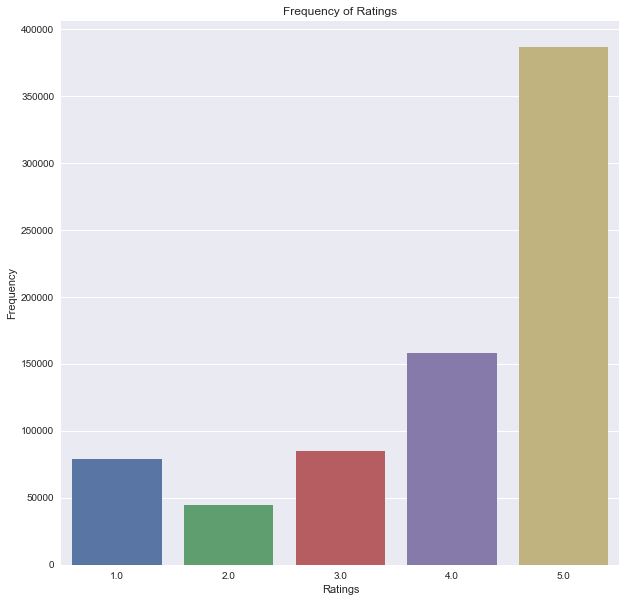

In [45]:
plt.figure(figsize=(10,10))
#plt.hist(df_user_item_rating.overall, bins=5)
sns.countplot(df_user_item_rating.overall)
plt.title('Frequency of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

In [46]:
# Take a look at the average rating of each movie. To do so, we can group the dataset by the asin of the product
# and then calculate the mean of the rating for each product and sort the ratings in the descending order 
# of their average ratings: 
mean_ratings = df_user_item_rating.groupby('asin')['overall'].mean().sort_values(ascending=False)
mean_ratings.head()
# mean_ratings = ratings.groupby(['timestamp', 'genres'], as_index=False)['rating'].aggregate(np.mean)

asin
B00HBDAGH6    5.0
B00HDTSTKY    5.0
B00AFAHUXU    5.0
B004W967J8    5.0
B00IHNXIWY    5.0
Name: overall, dtype: float64

In [47]:
# However we have a problem. A product can make it to the top of the above list even if only a single user
# has given it five stars. Therefore, the above stats can be misleading. Normally, a product which is really
# a good one gets a higher rating by a large number of users.
count_ratings = df_user_item_rating.groupby('asin')['overall'].count().sort_values(ascending=False)
count_ratings.head()

asin
B00FAPF5U0    6282
B0086700CM    4637
B00992CF6W    4018
B009UX2YAC    3814
B0064X7B4A    3763
Name: overall, dtype: int64

In [48]:
# Now we can see some really good product at the top. The above list supports our point that good products
# normally receive higher ratings. Now we know that both the average rating per product and the number of
# ratings per product are import attributes. 

# Let's create a new dataframe that contains both of these attributes
mean_count_ratings = pd.DataFrame(df_user_item_rating.groupby('asin')['overall'].mean())

# Next, we need to add the number of ratings for a product to the mean_count_ratings dataframe.
mean_count_ratings['count_ratings'] = pd.DataFrame(df_user_item_rating.groupby('asin')['overall'].count())

# let's take a look at our newly created dataframe
mean_count_ratings.sort_values(ascending=False, by='count_ratings').head(20)
# Output: We see product asin, along with the average rating and number of ratings per product.

,overall,count_ratings
asin,,
B00FAPF5U0,4.364534,6282
B0086700CM,4.566314,4637
B00992CF6W,4.472872,4018
B009UX2YAC,4.581542,3814
B0064X7B4A,4.238639,3763
B00DJFIMW6,4.339149,3668
B0054JZC6E,4.245518,3458
B0063IH60K,4.423837,3440
B005ZXWMUS,4.298044,3221


/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


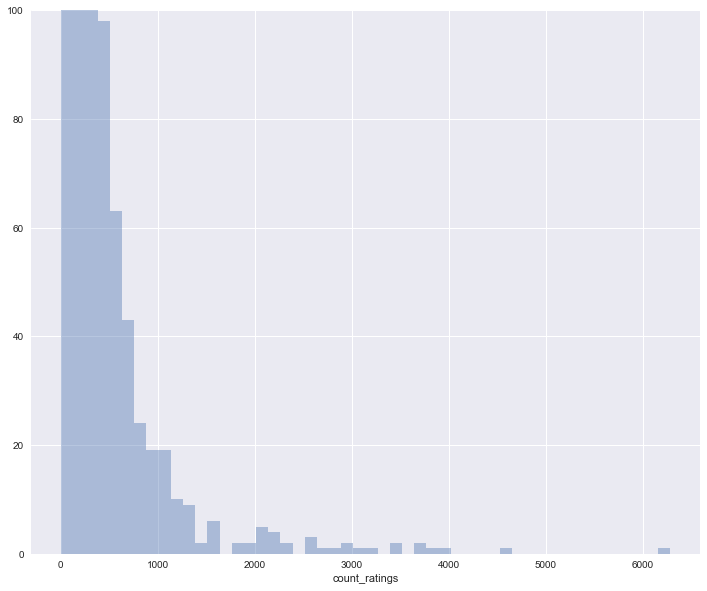

In [49]:
# Let's plot a histogram for the number of ratings represented by the "count_ratings" column in the above dataframe
plt.figure(figsize=(12,10))
sns.distplot(mean_count_ratings.count_ratings, bins=50, kde=False)
plt.rcParams['patch.force_edgecolor'] = False
plt.ylim(0,100)
plt.show()

In [50]:
# From the output, you can see that most of the products have received less than 2000 ratings.
# While the number of products having more than 4000 ratings is very low.

/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


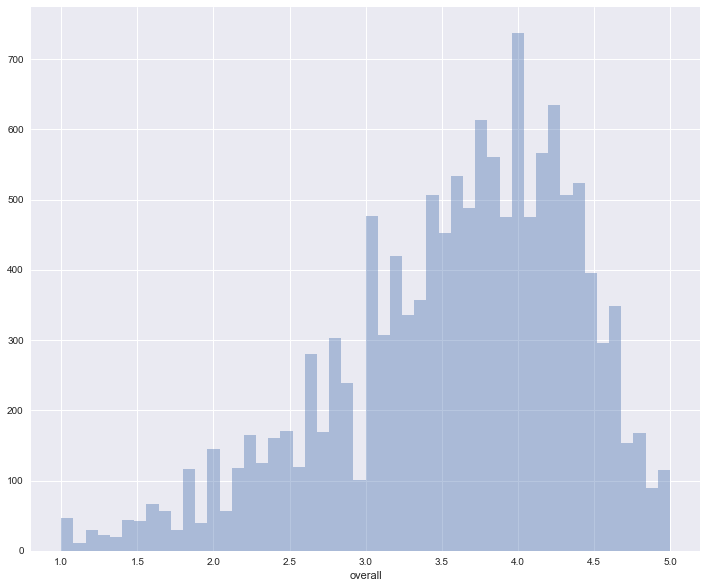

In [51]:
# let's plot a histogram for average ratings:
plt.figure(figsize=(12,10))
sns.distplot(mean_count_ratings.overall, bins=50, kde=False)
plt.rcParams['patch.force_edgecolor'] = False
plt.show()

In [52]:
# You can see that the integer values have taller bars than the floating values since user assign rating
# as integer value i.e. 1,2,3,4 or 5. Furthermore, we see that the data has a weak normal distribution
# with the mean of around 4. There are a few outliers in the data.

/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 720x432 with 0 Axes>

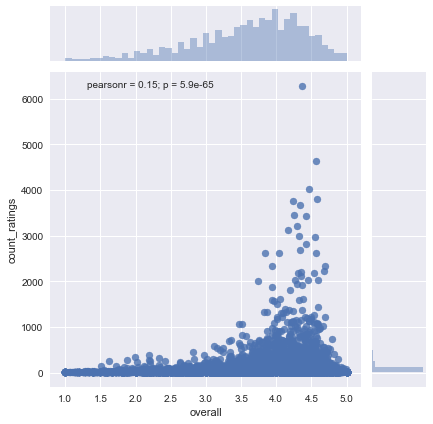

In [53]:
# We expect that products with a higher number of ratings usually have a high average rating as well
# since a good product is normally well-known and a well-known product is bough by a large number of people,
# and thus usually has a higher rating. 
# We will plot average ratings against the number of ratings

plt.figure(figsize=(10,6))
sns.jointplot(x="overall", y="count_ratings", data=mean_count_ratings, alpha=0.8)
plt.show()

In [54]:
# The output shows that, in general, products with higher average ratings actually have more number of ratings,
# compared with products that have lower average ratings.

We spent a bit of time on visualizing and preprocessing our data. Now it is time to make a recommendation; see ...

rating matrix with one row per user and one column per movie using the 'pivot table' function

In [113]:
ratings = df_Apps[:1000].pivot(index='reviewerID', columns='asin', values='overall').fillna(0)

In [177]:
ratings.head()

asin,B004A9SDD8,B004AFQAUA,B004AHBBPW,B004ALVL6W,B004AMAIZQ,B004AMDC86,B004ANC00Q,B004ANE2WU,B004ANMWPY,B004AZH4C8,B004AZSY4K,B004BN3YQE,B004C4FL5Y,B004CN7Y4G,B004DJXQDC,B004DKSUXC,B004DLLNFS,B004DLNBDA,B004DLNC4I
reviewerID,,,,,,,,,,,,,,,,,,,
A08839553NG2E57YWLLVC,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A104HHVVMF2GR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ANCEOWK5GBN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NF7H12HFAD1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ZT9TI8O98K4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
R = ratings.values
user_ratings_mean = np.mean(R, axis=1)
rating_demand = R - user_ratings_mean.reshape(-1,1)

In [119]:
U, sigma, Vt = svds(rating_demand, k=5) # k is the number of factors

# convert sigma to a diagonal matrix form
sigma = np.diag(sigma)

In [164]:
# Making predictions from the decomposed matrices
# We need to add the user means back to get the predicted 5-star ratings
full_ratings = pd.DataFrame(np.dot(U, Vt) + user_ratings_mean.reshape(-1,1), columns=ratings.columns)

In [180]:
# Making predictions for user 1 top 10
prediction_user_0 = full_ratings.loc[0].sort_values(ascending=False)[:10]
prediction_user_0

asin
B004AHBBPW    0.367366
B004AMDC86    0.260086
B004ANMWPY    0.259959
B004AZH4C8    0.259222
B004DJXQDC    0.258940
B004ANE2WU    0.258874
B004AMAIZQ    0.258689
B004DKSUXC    0.258660
B004CN7Y4G    0.258465
B004BN3YQE    0.258412
Name: 0, dtype: float64

In [56]:
def get_interactions():
    df_user_item_rating = pd.read_csv('cleaned_user_item_rating.csv')
    df_user_item_rating = df_user_item_rating.drop(columns=['Unnamed: 0'])[:10000]
    df_user_item_rating['reviewerID'] = pd.factorize(df_user_item_rating['reviewerID'])[0] + 1
    df_user_item_rating['asin'] = pd.factorize(df_user_item_rating['asin'])[0] + 1
    
    # number of unique users
    n_users = df_user_item_rating.reviewerID.unique().shape[0]
    #print('{} unique users'.format(n_users))
    
    # number of unique items
    n_items = df_user_item_rating.asin.unique().shape[0]
    #print('{} unique items'.format(n_items))
    
    interactions = np.zeros((n_users, n_items))
    for row in df_user_item_rating.itertuples():
        interactions[row[1] - 1, row[2] - 1] = row[3]
    return interactions, n_users, n_items

In [102]:
print(f'number of unique products: {n_items}')
print(f'number of unique users: {n_users}')

number of unique products: 113
number of unique users: 8235


Given the underwhelming performance of our matrix factorization model, we try a simple feedforward recommendation system instead. 


Input of this neural network is a pair of user and item represented by their IDs. Both user and item IDs first pass through an embedding layer. The output of the embedding layer, which are two embedding vectors, are then concatenated into one and passed into a linear network. 


Output of the linear network is one dimensional - representing the rating for the user-item pair. 

The model is fit the same way as the matrix factorization model and uses the standard PyTorch approach of forward passing, computing the loss, backpropagating and updating weights.

In [57]:
def train_test_split(interactions, n=2):
    """
    Split an interactions matrix into training and test sets.
    Parameters
    ----------
    interactions : np.ndarray
    n : int (default=2)
        Number of items to select / row to place into test.
    Returns
    -------
    train : np.ndarray
    test : np.ndarray
    """
    test = np.zeros(interactions.shape)
    train = interactions.copy()
    for user in range(interactions.shape[0]):
        if interactions[user, :].nonzero()[0].shape[0] > n:
            test_interactions = np.random.choice(interactions[user, :].nonzero()[0],
                                                 size=n,
                                                 replace=False)
            train[user, test_interactions] = 0.
            test[user, test_interactions] = interactions[user, test_interactions]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test

In [58]:
def interactions_train_test_split(interactions):
    interactions, _, _ = get_interactions()
    train, test = train_test_split(interactions)
    train = sparse.coo_matrix(train)
    test = sparse.coo_matrix(test)
    return train, test

In [59]:
# normalize into [0,1]
def normalize(ratings):
    ratings = ratings.copy()
    max_ratings = ratings.max()
    ratings = ratings*1.0/max_ratings
    return ratings

In [60]:
def seq_rating(training_data):
    n_users = training_data.shape[0]
    sequence = []
    ratings = []
    for users in range(0, n_users):
        sequence.append(np.nonzero(training_data.toarray()[users])[0])
        ratings.append(training_data.toarray()[users][[np.nonzero(training_data.toarray()[users])[0]]])
    return sequence, ratings

In [61]:
interactions, n_users, n_items = get_interactions()

In [62]:
training_data, test_data = interactions_train_test_split(interactions)

In [63]:
training_data.data = normalize(training_data.data)
test_data.data = normalize(test_data.data)

# Matrix Factorization

In [64]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors,
                                               sparse=True)
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors,
                                               sparse=True)

    def forward(self, user, item):
        # matrix multiplication
        return (self.user_factors(user)*self.item_factors(item)).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)

## Neural Network

In [65]:
class NeuralNetwork(nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors,
                                               sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors,
                                               sparse=True)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H1)
        self.linear2 = torch.nn.Linear(H1, D_out)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        h1_relu = F.relu(self.linear1(x))
        output_scores = self.linear2(h1_relu)
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

## Train the model

In [66]:
def train_test(model, training_data, test_data, epoche, lr=1e-5):
    loss_fn = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr)

    # Sort our train and test data
    training_data = np.array(training_data.toarray())
    users_train, items_train = training_data.nonzero()
    p = np.random.permutation(len(users_train))
    users_train, items_train = users_train[p], items_train[p]
    
    test_data = np.array(test_data.toarray())
    users_test, items_test = test_data.nonzero()
    
    mean_train_loss_hist = []
    mean_test_loss_hist = []
    for epoch in range(0, epoche):
        train_loss_hist = []
        test_loss_hist = []
        #t = 0
        #p = np.random.permutation(len(users))
        #users, items = users[p], items[p]
        for user, item in zip(*(users_train, items_train)):
            #t = t + 1
            # get user, item and rating data
            rating = torch.FloatTensor([training_data[user, item]])
            user = torch.LongTensor([int(user)])
            item = torch.LongTensor([int(item)])
    
            # predict and calculate loss
            prediction = model.forward(user, item).flatten()
            loss = torch.sqrt(loss_fn(prediction, rating))
    
            # backpropagate
            loss.backward()

            # update weights
            optimizer.step()
    
            # Loss
            train_loss_hist.append(loss.item())
        
        for user, item in zip(*(users_test, items_test)):
            # get user, item and rating data
            rating_test = torch.FloatTensor([test_data[user, item]])
            user = torch.LongTensor([int(user)])
            item = torch.LongTensor([int(item)])
    
            # predict and calculate loss
            prediction = model.forward(user, item).flatten()
            loss = torch.sqrt(loss_fn(prediction, rating_test))
            
            # Loss
            test_loss_hist.append(loss.item())
            
        mean_train_loss_hist.append(np.mean(train_loss_hist))
        mean_test_loss_hist.append(np.mean(test_loss_hist))
        
        print('Epoch:[{}/{}], train loss : {:.4f}, test loss : {:.4f}'\
              .format(epoch+1, epoche, np.mean(train_loss_hist), np.mean(test_loss_hist)))
        
    # Plotting our test and val losses
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(mean_train_loss_hist, label='train')
    ax.plot(mean_test_loss_hist, label='test')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    #plt.ylim(0.2,0.8)
    plt.show()

In [69]:
H1 = 128
D_out = 1
model_nn = NeuralNetwork(n_users, n_items, n_factors=40, H1=H1, D_out=D_out)
model_mf = MatrixFactorization(n_users, n_items, n_factors=20)

Epoch:[1/1], train loss : 2.8026, test loss : 2.7149


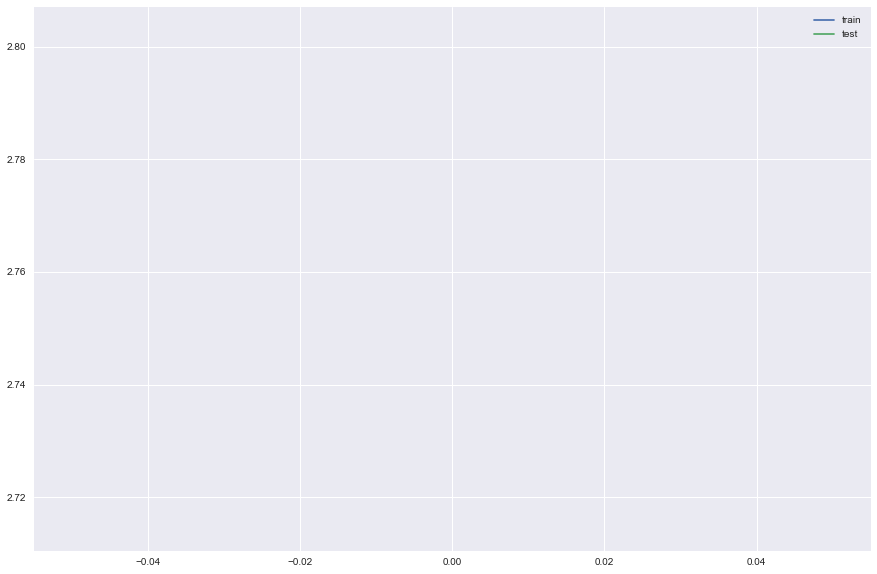

In [70]:
train_test(model_mf, training_data, test_data, 1)

In [ ]:
train_test(model, training_data, test_data, 10)